In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Data handling
import pandas as pd
import numpy as np

# Data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn modules
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split

# Data acquisition
from pydataset import data

# Data modeling
from model import map_setosa_knn, train_validate_test_split

# Data
import acquire
import prepare

In [2]:
raw_data = acquire.get_telco_data()
raw_data.head()

,Unnamed: 0,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,...,payment_type_id,monthly_charges,total_charges,churn,contract_type_id.1,contract_type,payment_type_id.1,payment_type,internet_service_type_id.1,internet_service_type
0,0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,...,2,65.6,593.3,No,2,One year,2,Mailed check,1,DSL
1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,...,2,59.9,542.4,No,1,Month-to-month,2,Mailed check,1,DSL
2,2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,...,1,73.9,280.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
3,3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,...,1,98.0,1237.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
4,4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,...,2,83.9,267.4,Yes,1,Month-to-month,2,Mailed check,2,Fiber optic


In [3]:
pd.crosstab(raw_data.internet_service_type_id, raw_data.internet_service_type)

internet_service_type,DSL,Fiber optic,None
internet_service_type_id,,,
1,2421,0,0
2,0,3096,0
3,0,0,1526


In [4]:
pd.crosstab(raw_data.contract_type_id, raw_data.contract_type)

contract_type,Month-to-month,One year,Two year
contract_type_id,,,
1,3875,0,0
2,0,1473,0
3,0,0,1695


In [5]:
pd.crosstab(raw_data.payment_type_id, raw_data.payment_type)

payment_type,Bank transfer (automatic),Credit card (automatic),Electronic check,Mailed check
payment_type_id,,,,
1,0,0,2365,0
2,0,0,0,1612
3,1544,0,0,0
4,0,1522,0,0


In [6]:
df = raw_data.copy()

**Note**: `payment_type_id`, `internet_service_type_id`, and `contract_type_id` are all duplicated by `payment_type`, `internet_service_type`, and `contract_type`. We can drop the id columns. `customer_id` may not be necessary either. We can drop it for now and if we end up needing it in the end for some reason, we can go back and change that.

In [7]:
df.drop(columns=['payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id'], inplace=True)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  7043 non-null   int64  
 1   gender                      7043 non-null   object 
 2   senior_citizen              7043 non-null   int64  
 3   partner                     7043 non-null   object 
 4   dependents                  7043 non-null   object 
 5   tenure                      7043 non-null   int64  
 6   phone_service               7043 non-null   object 
 7   multiple_lines              7043 non-null   object 
 8   online_security             7043 non-null   object 
 9   online_backup               7043 non-null   object 
 10  device_protection           7043 non-null   object 
 11  tech_support                7043 non-null   object 
 12  streaming_tv                7043 non-null   object 
 13  streaming_movies            7043 

**Note**: Total charges is showing as an object value instead of a float value. Before we can visualize this in our summary process, we will need to clean this. 

In [9]:
df['total_charges'].value_counts()

           11
20.2       11
19.75       9
19.9        8
20.05       8
           ..
2387.75     1
6302.8      1
2058.5      1
829.55      1
3707.6      1
Name: total_charges, Length: 6531, dtype: int64

The `total_charges` column contains whitespace characters. Lets see what those are connected to:

In [12]:
df[df.total_charges == ' ']

,Unnamed: 0,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,paperless_billing,monthly_charges,total_charges,churn,contract_type_id.1,contract_type,payment_type_id.1,payment_type,internet_service_type_id.1,internet_service_type
945,945,Female,0,Yes,Yes,0,No,No phone service,Yes,Yes,...,No,56.05,,No,3,Two year,4,Credit card (automatic),1,DSL
1731,1731,Female,0,Yes,Yes,0,Yes,No,No internet service,No internet service,...,No,20.00,,No,3,Two year,2,Mailed check,3,None
1906,1906,Male,0,No,Yes,0,Yes,Yes,Yes,Yes,...,Yes,61.90,,No,3,Two year,3,Bank transfer (automatic),1,DSL
2025,2025,Male,0,Yes,Yes,0,Yes,No,No internet service,No internet service,...,Yes,19.70,,No,2,One year,2,Mailed check,3,None
2176,2176,Male,0,No,Yes,0,Yes,No,No internet service,No internet service,...,No,20.25,,No,3,Two year,2,Mailed check,3,None
2250,2250,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,...,No,25.35,,No,3,Two year,2,Mailed check,3,None
2855,2855,Female,0,Yes,Yes,0,Yes,Yes,No,Yes,...,No,73.35,,No,3,Two year,2,Mailed check,1,DSL
3052,3052,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,...,No,25.75,,No,3,Two year,2,Mailed check,3,None
3118,3118,Female,0,Yes,Yes,0,No,No phone service,Yes,No,...,Yes,52.55,,No,3,Two year,3,Bank transfer (automatic),1,DSL
4054,4054,Female,0,Yes,Yes,0,Yes,No,Yes,Yes,...,No,80.85,,No,3,Two year,2,Mailed check,1,DSL


In [13]:
df[df.tenure == 0]

,Unnamed: 0,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,paperless_billing,monthly_charges,total_charges,churn,contract_type_id.1,contract_type,payment_type_id.1,payment_type,internet_service_type_id.1,internet_service_type
945,945,Female,0,Yes,Yes,0,No,No phone service,Yes,Yes,...,No,56.05,,No,3,Two year,4,Credit card (automatic),1,DSL
1731,1731,Female,0,Yes,Yes,0,Yes,No,No internet service,No internet service,...,No,20.00,,No,3,Two year,2,Mailed check,3,None
1906,1906,Male,0,No,Yes,0,Yes,Yes,Yes,Yes,...,Yes,61.90,,No,3,Two year,3,Bank transfer (automatic),1,DSL
2025,2025,Male,0,Yes,Yes,0,Yes,No,No internet service,No internet service,...,Yes,19.70,,No,2,One year,2,Mailed check,3,None
2176,2176,Male,0,No,Yes,0,Yes,No,No internet service,No internet service,...,No,20.25,,No,3,Two year,2,Mailed check,3,None
2250,2250,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,...,No,25.35,,No,3,Two year,2,Mailed check,3,None
2855,2855,Female,0,Yes,Yes,0,Yes,Yes,No,Yes,...,No,73.35,,No,3,Two year,2,Mailed check,1,DSL
3052,3052,Male,0,Yes,Yes,0,Yes,Yes,No internet service,No internet service,...,No,25.75,,No,3,Two year,2,Mailed check,3,None
3118,3118,Female,0,Yes,Yes,0,No,No phone service,Yes,No,...,Yes,52.55,,No,3,Two year,3,Bank transfer (automatic),1,DSL
4054,4054,Female,0,Yes,Yes,0,Yes,No,Yes,Yes,...,No,80.85,,No,3,Two year,2,Mailed check,1,DSL


It looks like customers with zero tenure have no total charges, and this is being represented by the whitespace character. Dropping these observations for now.

In [16]:
df['total_charges'] = df['total_charges'].str.strip()

In [17]:
df = df[df.total_charges != '']

In [18]:
# Confirm that these rows were dropped
df[df.tenure == 0]

,Unnamed: 0,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,paperless_billing,monthly_charges,total_charges,churn,contract_type_id.1,contract_type,payment_type_id.1,payment_type,internet_service_type_id.1,internet_service_type


In [19]:
# Convert datatype
df['total_charges'] = df.total_charges.astype(float)

In [20]:
# View numeric summary statistics
df.describe()

,Unnamed: 0,senior_citizen,tenure,monthly_charges,total_charges,contract_type_id.1,payment_type_id.1,internet_service_type_id.1
count,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000,7032.000000
mean,3522.306314,0.162400,32.421786,64.798208,2283.300441,1.688567,2.315557,1.872582
std,2034.073173,0.368844,24.545260,30.085974,2266.771362,0.832934,1.149523,0.737271
min,0.000000,0.000000,1.000000,18.250000,18.800000,1.000000,1.000000,1.000000
25%,1759.750000,0.000000,9.000000,35.587500,401.450000,1.000000,1.000000,1.000000
50%,3524.500000,0.000000,29.000000,70.350000,1397.475000,1.000000,2.000000,2.000000
75%,5283.250000,0.000000,55.000000,89.862500,3794.737500,2.000000,3.000000,2.000000
max,7042.000000,1.000000,72.000000,118.750000,8684.800000,3.000000,4.000000,3.000000


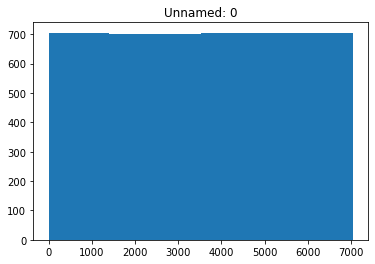

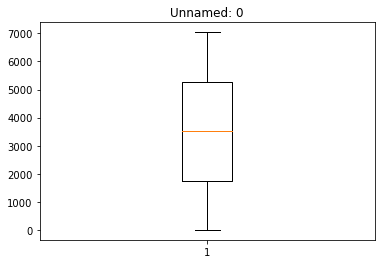

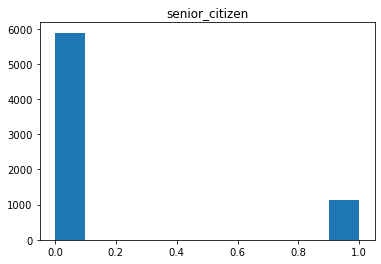

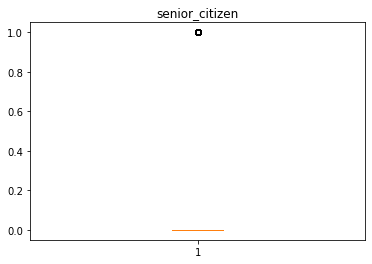

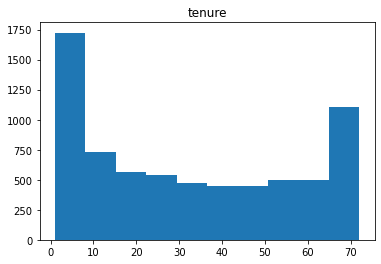

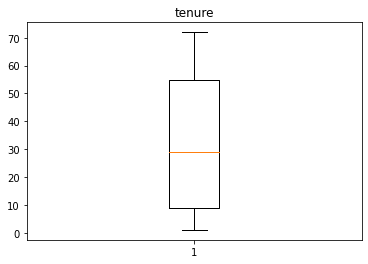

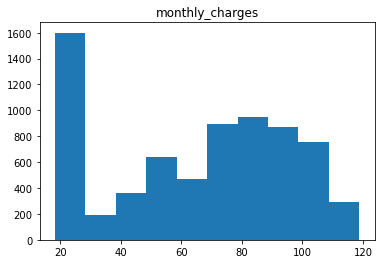

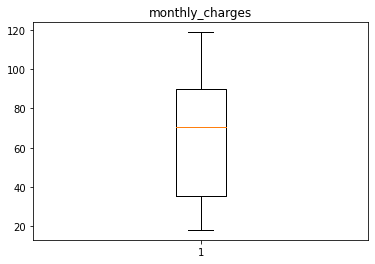

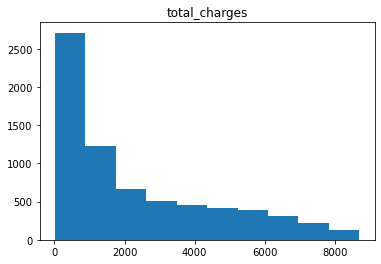

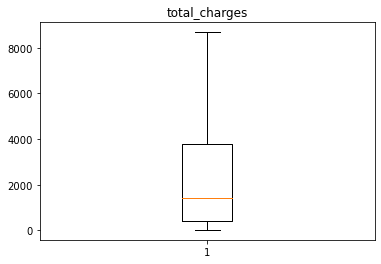

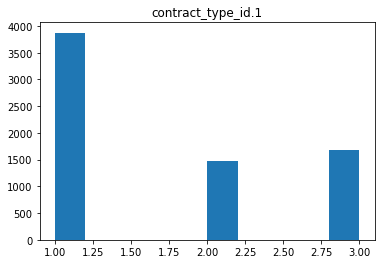

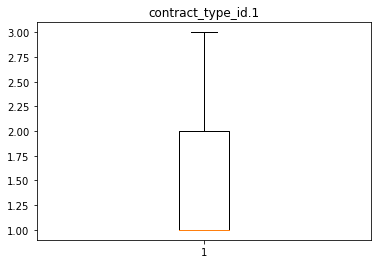

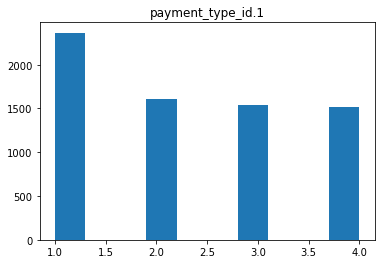

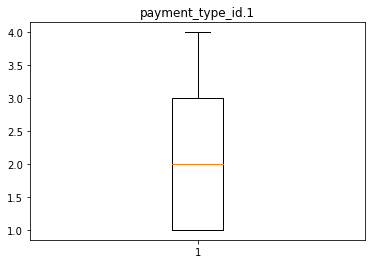

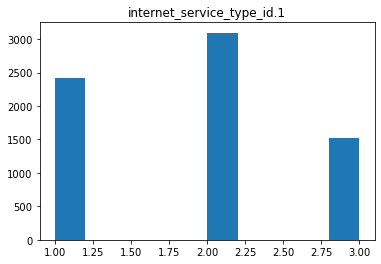

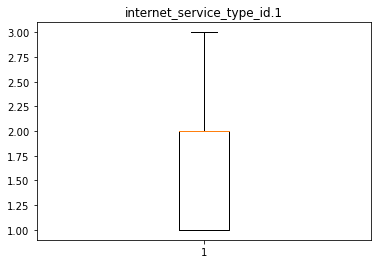

In [21]:
# Plot numeric columns
num_cols = df.columns[[(df[col].dtype == 'int64') or (df[col].dtype == 'float64') for col in df.columns]]
for col in num_cols:
    plt.hist(df[col])
    plt.title(col)
    plt.show()
    plt.boxplot(df[col])
    plt.title(col)
    plt.show()

In [23]:
# Use .describe with object columns
obj_cols = df.columns[[df[col].dtype == 'O' for col in df.columns]]
obj_cols

Index(['gender', 'partner', 'dependents', 'phone_service', 'multiple_lines',
       'online_security', 'online_backup', 'device_protection', 'tech_support',
       'streaming_tv', 'streaming_movies', 'paperless_billing', 'churn',
       'contract_type', 'payment_type', 'internet_service_type'],
      dtype='object')

In [24]:
for col in obj_cols:
    print(col.upper())
    print('Count:')
    print(df[col].value_counts())
    print('\n')
    print('Proportions:')
    print(df[col].value_counts(normalize=True, dropna=False))
    print('--------------------------')
    print('\n')

GENDER
Count:
Male      3549
Female    3483
Name: gender, dtype: int64


Proportions:
Male      0.504693
Female    0.495307
Name: gender, dtype: float64
--------------------------


PARTNER
Count:
No     3639
Yes    3393
Name: partner, dtype: int64


Proportions:
No     0.517491
Yes    0.482509
Name: partner, dtype: float64
--------------------------


DEPENDENTS
Count:
No     4933
Yes    2099
Name: dependents, dtype: int64


Proportions:
No     0.701507
Yes    0.298493
Name: dependents, dtype: float64
--------------------------


PHONE_SERVICE
Count:
Yes    6352
No      680
Name: phone_service, dtype: int64


Proportions:
Yes    0.903299
No     0.096701
Name: phone_service, dtype: float64
--------------------------


MULTIPLE_LINES
Count:
No                  3385
Yes                 2967
No phone service     680
Name: multiple_lines, dtype: int64


Proportions:
No                  0.481371
Yes                 0.421928
No phone service    0.096701
Name: multiple_lines, dtype: float64
-

In [25]:
# encode binary categorical variables into numeric values
df['gender_encoded'] = df.gender.map({'Female': 1, 'Male': 0})
df['partner_encoded'] = df.partner.map({'Yes': 1, 'No': 0})
df['dependents_encoded'] = df.dependents.map({'Yes': 1, 'No': 0})
df['phone_service_encoded'] = df.phone_service.map({'Yes': 1, 'No': 0})
df['paperless_billing_encoded'] = df.paperless_billing.map({'Yes': 1, 'No': 0})
df['churn_encoded'] = df.churn.map({'Yes': 1, 'No': 0})

In [26]:
# Using get_dummies

dummy_df = pd.get_dummies(df[['multiple_lines', \
                              'online_security', \
                              'online_backup', \
                              'device_protection', \
                              'tech_support', \
                              'streaming_tv', \
                              'streaming_movies', \
                              'contract_type', \
                              'internet_service_type', \
                              'payment_type']], dummy_na=False, \
                              drop_first=True)
dummy_df

,multiple_lines_No phone service,multiple_lines_Yes,online_security_No internet service,online_security_Yes,online_backup_No internet service,online_backup_Yes,device_protection_No internet service,device_protection_Yes,tech_support_No internet service,tech_support_Yes,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0,0,0,0,0,1,0,0,0,1,...,1,0,0,1,0,0,0,0,0,1
1,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,1,0
3,0,0,0,0,0,1,0,1,0,0,...,1,0,1,0,0,1,0,0,1,0
4,0,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,0,0,0,0,0,1
7039,0,1,0,0,0,0,0,0,0,0,...,0,0,1,0,0,1,0,0,1,0
7040,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7041,0,0,0,1,0,0,0,1,0,1,...,0,0,1,0,1,0,0,0,0,1


In [27]:
df = pd.concat([df, dummy_df], axis=1)
df.head()

,Unnamed: 0,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,0,Female,0,Yes,Yes,9,Yes,No,No,Yes,...,1,0,0,1,0,0,0,0,0,1
1,1,Male,0,No,No,9,Yes,Yes,No,No,...,0,0,1,0,0,0,0,0,0,1
2,2,Male,0,No,No,4,Yes,No,No,No,...,0,0,0,0,0,1,0,0,1,0
3,3,Male,1,Yes,No,13,Yes,No,No,Yes,...,1,0,1,0,0,1,0,0,1,0
4,4,Female,1,Yes,No,3,Yes,No,No,No,...,1,0,0,0,0,1,0,0,0,1


New features: Most of these are garbage and have multiple issues with keeping them - think critically about whether any of these should be used (do they actually supply new information not already represented by the existing fields?) and if they need to be one-hot encoded if kept. 

In [29]:
# encode number_relationships by utilizing information from dependents_encoded and partner_encoded
df['number_relationships'] = df['dependents_encoded'] + df['partner_encoded']

In [30]:
# create some new columns
df['online_backup_bool'] = df.online_backup.map({'Yes': 1, 'No': 0, 'No internet service': 0}) 
df['online_security_bool'] = df.online_security.map({'Yes': 1, 'No': 0, 'No internet service': 0})

In [31]:
# encode number_online_services by utilizing information from online_security_encoded and online_backup_encoded
df['number_online_services'] = df['online_security_bool'] + df['online_backup_bool']

In [32]:
# encode tenure in years (rounded down) by utilizing information from tenure (currently stored in months)
df['yearly_tenure'] = df.tenure.apply(lambda x: math.floor(x/12))

NameError: name 'math' is not defined

In [33]:
# encode has_internet
df['has_internet'] = df.internet_service_type.apply(lambda x: 0 if x == 'None' else 1)

In [ ]:
df.drop(columns='Unnamed: 0')


In [34]:

def split_telco_data(df):
    '''
    This function performs split on telco data, stratify churn.
    Returns train, validate, and test dfs.
    '''
    train_validate, test = train_test_split(df, test_size=.2, 
                                        random_state=123, 
                                        stratify=df.churn)
    train, validate = train_test_split(train_validate, test_size=.2, 
                                   random_state=123, 
                                   stratify=train_validate.churn)
    return train, validate, test

In [42]:
def prep_telco_data(df):
    # Drop duplicate columns
    df.drop(columns=['Unnamed: 0','payment_type_id', 'internet_service_type_id', 'contract_type_id', 'customer_id'], inplace=True)
    
    
    # Drop null values stored as whitespace    
    df['total_charges'] = df['total_charges'].str.strip()
    df = df[df.total_charges != '']
    
    # Convert to correct datatype
    df['total_charges'] = df.total_charges.astype(float)
    
    # Convert binary categorical variables to numeric
    df['gender_encoded'] = df.gender.map({'Female': 1, 'Male': 0})
    df['partner_encoded'] = df.partner.map({'Yes': 1, 'No': 0})
    df['dependents_encoded'] = df.dependents.map({'Yes': 1, 'No': 0})
    df['phone_service_encoded'] = df.phone_service.map({'Yes': 1, 'No': 0})
    df['paperless_billing_encoded'] = df.paperless_billing.map({'Yes': 1, 'No': 0})
    df['churn_encoded'] = df.churn.map({'Yes': 1, 'No': 0})
    
    # Get dummies for non-binary categorical variables
    dummy_df = pd.get_dummies(df[['multiple_lines', \
                              'online_security', \
                              'online_backup', \
                              'device_protection', \
                              'tech_support', \
                              'streaming_tv', \
                              'streaming_movies', \
                              'contract_type', \
                              'internet_service_type', \
                              'payment_type']], dummy_na=False, \
                              drop_first=True)
    
    # Concatenate dummy dataframe to original 
    df = pd.concat([df, dummy_df], axis=1)
    
    return df

In [43]:
raw_data = acquire.get_telco_data()
raw_data.head()

,Unnamed: 0,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,internet_service_type_id,...,payment_type_id,monthly_charges,total_charges,churn,contract_type_id.1,contract_type,payment_type_id.1,payment_type,internet_service_type_id.1,internet_service_type
0,0,0002-ORFBO,Female,0,Yes,Yes,9,Yes,No,1,...,2,65.6,593.3,No,2,One year,2,Mailed check,1,DSL
1,1,0003-MKNFE,Male,0,No,No,9,Yes,Yes,1,...,2,59.9,542.4,No,1,Month-to-month,2,Mailed check,1,DSL
2,2,0004-TLHLJ,Male,0,No,No,4,Yes,No,2,...,1,73.9,280.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
3,3,0011-IGKFF,Male,1,Yes,No,13,Yes,No,2,...,1,98.0,1237.85,Yes,1,Month-to-month,1,Electronic check,2,Fiber optic
4,4,0013-EXCHZ,Female,1,Yes,No,3,Yes,No,2,...,2,83.9,267.4,Yes,1,Month-to-month,2,Mailed check,2,Fiber optic


In [44]:
telco_prepped = prep_telco_data(raw_data)
telco_prepped

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,1,0,0,1,0,0,0,0,0,1
1,Male,0,No,No,9,Yes,Yes,No,No,No,...,0,0,1,0,0,0,0,0,0,1
2,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,0,0,0,0,1,0,0,1,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,1,0,1,0,0,1,0,0,1,0
4,Female,1,Yes,No,3,Yes,No,No,No,No,...,1,0,0,0,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,0,No,No,13,Yes,No,Yes,No,No,...,0,0,0,1,0,0,0,0,0,1
7039,Male,0,Yes,No,22,Yes,Yes,No,No,No,...,0,0,1,0,0,1,0,0,1,0
7040,Male,0,No,No,2,Yes,No,No,Yes,No,...,0,0,0,0,0,0,0,0,0,1
7041,Male,0,Yes,Yes,67,Yes,No,Yes,No,Yes,...,0,0,1,0,1,0,0,0,0,1


# Exploratory Analysis

In [45]:
telco_prepped.head()

,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,...,streaming_tv_Yes,streaming_movies_No internet service,streaming_movies_Yes,contract_type_One year,contract_type_Two year,internet_service_type_Fiber optic,internet_service_type_None,payment_type_Credit card (automatic),payment_type_Electronic check,payment_type_Mailed check
0,Female,0,Yes,Yes,9,Yes,No,No,Yes,No,...,1,0,0,1,0,0,0,0,0,1
1,Male,0,No,No,9,Yes,Yes,No,No,No,...,0,0,1,0,0,0,0,0,0,1
2,Male,0,No,No,4,Yes,No,No,No,Yes,...,0,0,0,0,0,1,0,0,1,0
3,Male,1,Yes,No,13,Yes,No,No,Yes,Yes,...,1,0,1,0,0,1,0,0,1,0
4,Female,1,Yes,No,3,Yes,No,No,No,No,...,1,0,0,0,0,1,0,0,0,1
